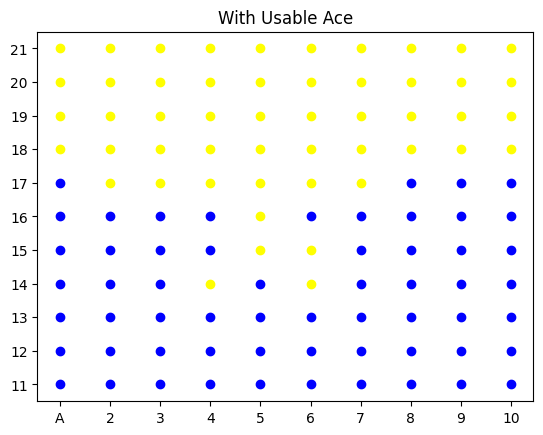

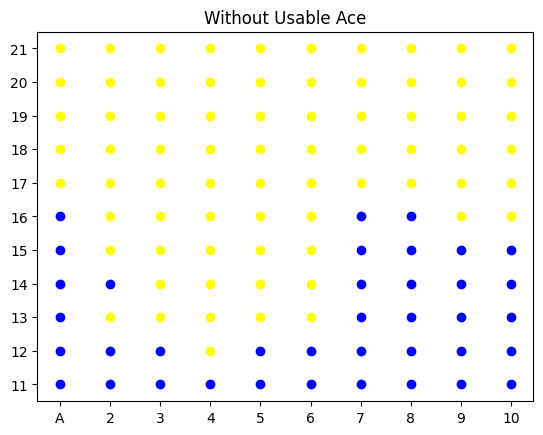

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 플레이어 클래스 정의
class Player(object):
    # 초기화 함수, 플레이어의 카드 합, 에이스 사용 여부, 딜러 카드 값을 받음
    def __init__(self, currentSum, usableAce, dealersCard):
        self.currentSum = currentSum  # 플레이어의 현재 점수
        self.dealersCard = dealersCard  # 딜러의 공개 카드
        self.usableAce = usableAce  # 에이스 사용 여부
        self.usingAce = self.usableAce  # 에이스 사용 상태

    # 카드를 받는 함수
    def ReceiveCard(self, card):
        # 에이스를 사용 중이고, 카드 합이 21을 초과하면 에이스를 1로 바꿔서 점수 최적화
        if self.usingAce and self.currentSum + card > 21:
            self.usingAce = False  # 에이스 사용 중지
            self.currentSum += card - 10  # 에이스를 1로 처리
        else:
            self.currentSum += card  # 단순히 카드를 더함

    # 현재 플레이어 상태를 반환
    def GetState(self):
        return (self.currentSum, self.usableAce, self.dealersCard)

    # 플레이어의 점수 값을 반환
    def GetValue(self):
        return self.currentSum

    # 플레이어가 히트를 해야 할지 결정하는 함수 (주어진 정책에 따라)
    def ShouldHit(self, policy):
        return policy[self.GetState()]

    # 플레이어가 버스트했는지 확인하는 함수
    def Bust(self):
        return self.GetValue() > 21  # 21을 넘으면 버스트

# 딜러 클래스 정의
class Dealer(object):
    # 딜러는 카드를 받으며, 처음 카드 리스트를 입력받음
    def __init__(self, cards):
        self.cards = cards  # 딜러가 가진 카드 리스트

    # 딜러가 카드를 받는 함수
    def ReceiveCard(self, card):
        self.cards.append(card)  # 카드 추가

    # 딜러의 점수를 계산하는 함수
    def GetValue(self):
        currentSum = 0  # 점수 합 초기화
        aceCount = 0  # 에이스의 수

        # 각 카드의 값을 합산
        for card in self.cards:
            if card == 1:  # 에이스는 1로 처리
                aceCount += 1
            else:
                currentSum += card  # 그 외 카드는 해당 숫자 값만큼 더함

        # 에이스는 1 또는 11로 사용할 수 있기 때문에, 에이스가 있을 경우 11로 처리
        while aceCount > 0:
            aceCount -= 1
            currentSum += 11  # 에이스를 11로 처리

            # 만약 점수가 21을 초과하면, 에이스를 다시 1로 처리
            if currentSum > 21:
                aceCount += 1
                currentSum -= 11
                currentSum += aceCount  # 다시 에이스를 1로 처리
                break

        return currentSum

    # 딜러가 히트를 해야할지 여부를 판단하는 함수
    def ShouldHit(self):
        if self.GetValue() >= 17:  # 17 이상이면 더 이상 카드 받지 않음
            return False
        else:
            return True

    # 딜러가 버스트했는지 확인하는 함수
    def Bust(self):
        return self.GetValue() > 21  # 21을 넘으면 버스트

# 상태-행동 쌍을 관리하는 클래스
class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = []  # 상태-행동 쌍 리스트
        self.stateActionMap = set()  # 상태-행동 쌍 중복 방지용 세트

    # 상태-행동 쌍을 추가하는 함수
    def AddPair(self, pair):
        if pair in self.stateActionMap:
            return  # 이미 있는 쌍은 추가하지 않음
        self.stateActionPairs.append(pair)  # 쌍을 리스트에 추가
        self.stateActionMap.add(pair)  # 세트에도 추가하여 중복 방지

# Q-러닝을 통해 정책을 개선하는 함수
def EvaluateAndImprovePolicy(qMap, policy, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1  # 해당 상태-행동 쌍이 나온 횟수 증가
        qMap[pair] = qMap[pair] + ((reward - qMap[pair]) / returns[pair])  # Q값 업데이트

        state = pair[0]
        shouldHit = False

        # Q값을 비교하여 히트할지 스탠드를 할지 결정
        if qMap[(state, True)] > qMap[(state, False)]:
            shouldHit = True

        policy[state] = shouldHit  # 정책 업데이트

# 새로운 카드를 생성하는 함수
def newCard():
    card = np.random.randint(1, 14)  # 1부터 13까지의 카드 값 생성

    if card > 9:  # 10, J, Q, K는 모두 10으로 취급
        return 10
    else:
        return card  # 1~9는 해당 숫자 값을 그대로 반환

# 한 에피소드를 실행하는 함수
def PlayEpisode(qMap, policy, returns):
    # 플레이어의 초기 상태 설정 (점수, 에이스 사용 여부, 딜러의 공개 카드)
    playerSum = np.random.randint(11, 22)
    dealerOpenCard = np.random.randint(1, 11)
    usableAce = bool(np.random.randint(0, 2))

    player = Player(playerSum, usableAce, dealerOpenCard)  # 플레이어 객체 생성
    dealer = Dealer([dealerOpenCard])  # 딜러 객체 생성

    stateActionInfo = StateActionInfo()  # 상태-행동 정보 객체 생성
    hitAction = bool(np.random.randint(0, 2))  # 플레이어가 히트할지 여부를 무작위로 결정
    stateActionInfo.AddPair((player.GetState(), hitAction))  # 상태-행동 쌍 추가

    # 플레이어가 히트를 선택하면 카드 받기
    if hitAction:
        player.ReceiveCard(newCard())

        # 플레이어가 버스트하지 않으면 계속 카드를 받는지 확인
        while not player.Bust() and player.ShouldHit(policy):
            stateActionInfo.AddPair((player.GetState(), True))  # 히트 상태 추가
            player.ReceiveCard(newCard())  # 카드 받기

    # 플레이어가 버스트하면 정책 업데이트
    if player.Bust():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
        return

    # 플레이어가 스탠드하면 딜러의 차례
    stateActionInfo.AddPair((player.GetState(), False))
    dealer.ReceiveCard(newCard())

    # 딜러가 버스트하지 않으면 계속 카드를 받음
    while not dealer.Bust() and dealer.ShouldHit():
        dealer.cards.append(newCard())

    # 딜러가 버스트하거나 플레이어가 더 높은 점수를 얻으면 승리
    if dealer.Bust() or dealer.GetValue() < player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 1)
    # 딜러가 더 높은 점수를 얻으면 패배
    elif dealer.GetValue() > player.GetValue():
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, -1)
    # 점수가 같으면 무승부
    else:
        EvaluateAndImprovePolicy(qMap, policy, returns, stateActionInfo.stateActionPairs, 0)

# Q값, 정책, 반환값 초기화
qMap = { }
policy = { }
returns = { }

# 가능한 모든 상태-행동 쌍에 대해 초기화
for playerSum in range(11, 22):
    for usableAce in range(2):
        for dealersCard in range(1, 11):
            playerState = (playerSum, bool(usableAce), dealersCard)
            qMap[(playerState, False)] = 0  # 스탠드 상태의 Q값 초기화
            qMap[(playerState, True)] = 0   # 히트 상태의 Q값 초기화
            returns[(playerState, False)] = 0
            returns[(playerState, True)] = 0

            # 초기 정책 설정 (21 또는 20이면 스탠드, 그 외에는 히트)
            if playerSum == 20 or playerSum == 21:
                policy[playerState] = False
            else:
                policy[playerState] = True

# 에피소드 100000번 실행하여 정책 학습
for i in range(100000):
    PlayEpisode(qMap, policy, returns)

# 학습된 정책을 시각화하기 위한 데이터 준비
x11 = []
y11 = []
x12 = []
y12 = []
x21 = []
y21 = []
x22 = []
y22 = []

# 정책에 따른 점수 상태에 맞는 위치 정보 저장
for playerState in policy:
    if playerState[1]:
        if policy[playerState]:
            x11.append(playerState[2] - 1)
            y11.append(playerState[0] - 11)
        else:
            x12.append(playerState[2] - 1)
            y12.append(playerState[0] - 11)
    else:
        if policy[playerState]:
            x21.append(playerState[2] - 1)
            y21.append(playerState[0] - 11)
        else:
            x22.append(playerState[2] - 1)
            y22.append(playerState[0] - 11)

# 에이스를 사용할 수 있을 때 출력
plt.figure(0)
plt.title('With Usable Ace')
plt.scatter(x11, y11, color='blue')
plt.scatter(x12, y12, color='yellow')
plt.xticks(range(10), ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.yticks(range(11), ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])

# 에이스를 사용할 수 없을 때 출력
plt.figure(1)
plt.title('Without Usable Ace')
plt.scatter(x21, y21, color='blue')
plt.scatter(x22, y22, color='yellow')
plt.xticks(range(10), ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.yticks(range(11), ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])

plt.show()
